In [53]:
# Reproducibility setup
import os
import random
import numpy as np
import torch

SEED = 1234

# 1) Python, NumPy, PyTorch seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# 2) CuDNN determinism settings (affects performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 3) Deterministic algorithms (PyTorch >= 1.8)
try:
    torch.use_deterministic_algorithms(True)
except Exception as e:
    print(f"Deterministic algorithms not fully available: {e}")

# 4) Optional: deterministic DataLoader shuffling
torch_gen = torch.Generator()
torch_gen.manual_seed(SEED)
print(f"Seeding complete with SEED={SEED}")

Seeding complete with SEED=1234


In [54]:
import pickle
N=20
n_epochs = 40
with open(f'processed_data_{N}.pkl', 'rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
X_mean = X_train.mean(axis=(0, 1), keepdims=True)
X_std  = X_train.std(axis=(0, 1), keepdims=True)

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std

X_train.shape

# y_mean = y_train.mean()
# y_std  = y_train.std()

# y_train = (y_train - y_mean) / y_std
# y_test  = (y_test  - y_mean) / y_std

(553, 20, 10)

In [55]:
# Build and train multivariate RNN model using PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoader for batch training
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"\nData converted to tensors:")
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"Batch size: {batch_size}")

Using device: cpu

Data converted to tensors:
X_train: torch.Size([553, 20, 10])
y_train: torch.Size([553])
Batch size: 16


In [56]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# ---------- Hyperparams (tune as needed) ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16
num_epochs = 20               # same as your num_epochs_new
learning_rate = 1e-3
weight_decay = 1e-5
patience = 7                  # early stopping patience on val loss
clip_norm = 1.0

# TCN architecture
input_size = X_train_tensor.shape[-1]   # 10 in your case
seq_len = X_train_tensor.shape[1]       # 20 in your case
output_size = 1                         # predicting one value
tcn_channels = [32, 32, 32]             # number of channels per level (small network)
kernel_size = 3
dropout = 0.3

# ---------- TCN building blocks ----------
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        # x shape: (B, C, L + pad)
        if self.chomp_size == 0:
            return x
        return x[:, :, : -self.chomp_size]

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.utils.weight_norm(
            nn.Conv1d(in_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.utils.weight_norm(
            nn.Conv1d(out_channels, out_channels, kernel_size,
                      stride=stride, padding=padding, dilation=dilation)
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        self.relu = nn.ReLU()

        # Init
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, input_size, tcn_channels, kernel_size=3, dropout=0.2, output_size=1):
        super().__init__()
        layers = []
        num_levels = len(tcn_channels)
        in_ch = input_size
        for i in range(num_levels):
            out_ch = tcn_channels[i]
            dilation_size = 2 ** i
            padding = (kernel_size - 1) * dilation_size
            layers.append(TemporalBlock(in_ch, out_ch, kernel_size, stride=1,
                                        dilation=dilation_size, padding=padding, dropout=dropout))
            in_ch = out_ch
        self.tcn = nn.Sequential(*layers)

        # final head: takes last time-step's features (we'll index last element)
        self.linear = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(tcn_channels[-1], tcn_channels[-1] // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(tcn_channels[-1] // 2, output_size)
        )

    def forward(self, x):
        # x: (B, seq_len, features)
        # convert to (B, C, L) for Conv1d where C=input_size, L=seq_len
        x = x.permute(0, 2, 1).contiguous()  # (B, features, seq_len)
        y = self.tcn(x)                       # (B, channels, seq_len)
        # take the last time-step features (causal conv => last index is final)
        last = y[:, :, -1]                    # (B, channels)
        out = self.linear(last)               # (B, output_size)
        return out.squeeze(-1)

# ---------- Instantiate model ----------
model_tcn = TCN(input_size=input_size,
                tcn_channels=tcn_channels,
                kernel_size=kernel_size,
                dropout=dropout,
                output_size=output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model_tcn.parameters(), lr=learning_rate, weight_decay=weight_decay)

print(model_tcn)

# ---------- Prepare data loaders with validation split ----------
# Use last 20% of train set as validation (time-series split)
val_size = int(0.2 * len(X_train_tensor))
if val_size < 1:
    raise ValueError("Training set too small for validation split. Reduce val fraction.")

X_val_tensor = X_train_tensor[-val_size:].to(device)
y_val_tensor = y_train_tensor[-val_size:].to(device)

X_train_sub = X_train_tensor[:-val_size]
y_train_sub = y_train_tensor[:-val_size]

train_dataset = TensorDataset(X_train_sub, y_train_sub)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# send test tensors to device (used only for logging at end)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

# ---------- Training with early stopping (based on validation loss) ----------
best_val = float('inf')
patience_counter = 0
train_losses = []
val_losses = []
test_losses = []

log_file_path = f'training_log_improved_TCN_{N}.txt'
with open(log_file_path, 'w') as logf:
    logf.write("TCN Model Training Log\n")
    logf.write("="*60 + "\n")
    logf.write(f"TCN channels: {tcn_channels}, kernel_size: {kernel_size}, dropout: {dropout}\n")
    logf.write("="*60 + "\n\n")
    logf.write("Epoch, Train Loss, Val Loss, Test Loss\n")

    for epoch in range(1, num_epochs + 1):
        model_tcn.train()
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            preds = model_tcn(batch_X)            # shape (B,)
            loss = criterion(preds, batch_y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_tcn.parameters(), clip_norm)
            optimizer.step()

            epoch_loss += loss.item() * batch_X.size(0)

        avg_train_loss = epoch_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        # Validation (no grad)
        model_tcn.eval()
        with torch.no_grad():
            val_preds = model_tcn(X_val_tensor)
            val_loss = criterion(val_preds, y_val_tensor).item()
            val_losses.append(val_loss)

            # Test loss for logging only
            test_preds = model_tcn(X_test_tensor)
            test_loss = criterion(test_preds, y_test_tensor).item()
            test_losses.append(test_loss)

        log_line = f"{epoch},{avg_train_loss:.6e},{val_loss:.6e},{test_loss:.6e}"
        logf.write(log_line + "\n")

        # Early stopping / checkpoint
        if val_loss < best_val - 1e-12:
            best_val = val_loss
            patience_counter = 0
            best_epoch = epoch
            torch.save(model_tcn.state_dict(), f'best_tcn_{N}.pth')
            best_note = " ← best"
        else:
            patience_counter += 1
            best_note = ""

        if epoch % 5 == 0 or patience_counter == 0:
            print(f"Epoch {epoch}/{num_epochs}  Train: {avg_train_loss:.6e}  Val: {val_loss:.6e}  Test: {test_loss:.6e}{best_note}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch} (no improve for {patience} epochs). Best val: {best_val:.6e} at epoch {best_epoch}")
            break

# ---------- Load best model and final test evaluation ----------
model_tcn.load_state_dict(torch.load(f'best_tcn_{N}.pth', map_location=device))
model_tcn.eval()
with torch.no_grad():
    final_test_preds = model_tcn(X_test_tensor).cpu().numpy()
    final_test_loss = criterion(torch.from_numpy(final_test_preds), y_test_tensor.cpu()).item()

print("Best val loss:", best_val)
print("Final test loss (best model):", final_test_loss)

# Optionally: save losses / predictions for plotting
np.savez(f'tcn_training_results_N{N}.npz',
         train_losses=np.array(train_losses),
         val_losses=np.array(val_losses),
         test_losses=np.array(test_losses),
         final_test_preds=final_test_preds)



TCN(
  (tcn): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(10, 32, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.3, inplace=False)
      (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.3, inplace=False)
      (net): Sequential(
        (0): Conv1d(10, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (1): Chomp1d()
        (2): ReLU()
        (3): Dropout(p=0.3, inplace=False)
        (4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(2,))
        (5): Chomp1d()
        (6): ReLU()
        (7): Dropout(p=0.3, inplace=False)
      )
      (downsample): Conv1d(10, 32, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(2,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
  

/opt/miniconda3/envs/dsml/lib/python3.13/site-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Epoch 1/20  Train: 7.174680e-02  Val: 2.180868e-02  Test: 1.437827e-02 ← best
Epoch 2/20  Train: 2.404498e-02  Val: 1.764452e-02  Test: 1.014206e-02 ← best
Epoch 3/20  Train: 1.680382e-02  Val: 1.067977e-02  Test: 7.052989e-03 ← best
Epoch 4/20  Train: 8.677337e-03  Val: 5.351124e-03  Test: 4.705592e-03 ← best
Epoch 5/20  Train: 7.144457e-03  Val: 2.977011e-03  Test: 2.748081e-03 ← best
Epoch 6/20  Train: 6.786835e-03  Val: 2.003053e-03  Test: 1.857797e-03 ← best
Epoch 7/20  Train: 3.245171e-03  Val: 1.511241e-03  Test: 1.248076e-03 ← best
Epoch 8/20  Train: 2.644020e-03  Val: 9.983862e-04  Test: 8.949208e-04 ← best
Epoch 9/20  Train: 1.685616e-03  Val: 6.867584e-04  Test: 5.954523e-04 ← best
Epoch 10/20  Train: 1.437439e-03  Val: 4.284563e-04  Test: 4.433885e-04 ← best
Epoch 11/20  Train: 1.857180e-03  Val: 3.558051e-04  Test: 3.761922e-04 ← best
Epoch 12/20  Train: 8.892309e-04  Val: 2.946741e-04  Test: 3.160096e-04 ← best
Epoch 13/20  Train: 8.857979e-04  Val: 2.711677e-04  Test: 3.

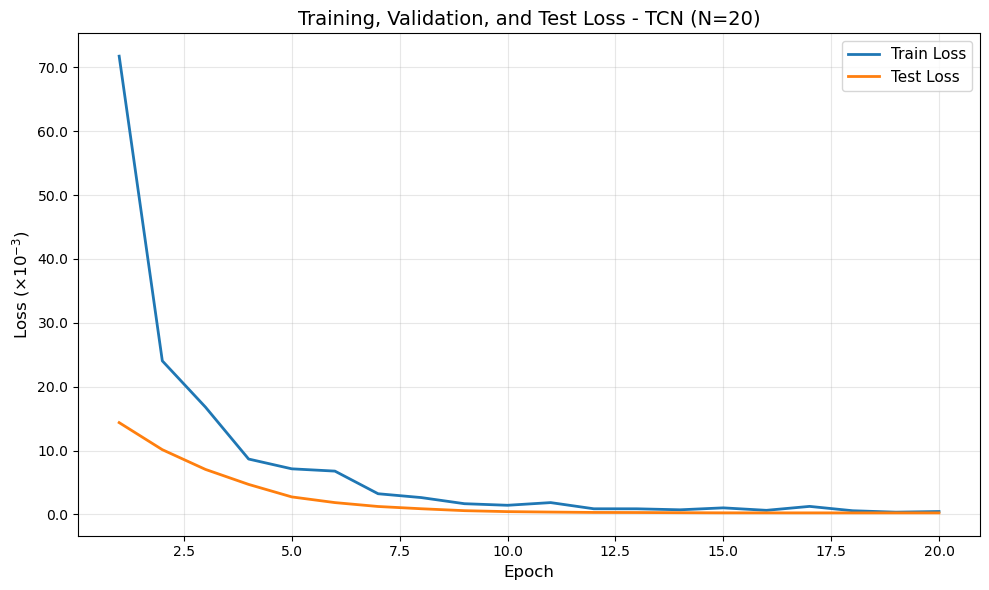

Showing epochs 1-50
Train Loss at epoch 20: 0.000463
Val Loss at epoch 20: 0.000174
Test Loss at epoch 20: 0.000248
Plot saved to: ./progress_report/media/training_loss_improved_TCN_20.pdf


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load training log for current N
log_path = f'training_log_improved_TCN_{N}.txt'
with open(log_path, 'r') as f:
    lines = f.readlines()

# Parse the log file written as CSV lines: epoch,train,val,test
epochs = []
train_losses = []
val_losses = []
test_losses = []

for line in lines:
    line = line.strip()
    # Skip headers and separators
    if (not line) or line.startswith('=') or line.startswith('TCN Model Training Log') or line.startswith('Epoch,'):
        continue
    # Accept lines that look like numeric CSV: e.g., 1,1.23e-03,1.11e-03,1.50e-03
    parts = line.split(',')
    if len(parts) == 4 and parts[0].strip().isdigit():
        try:
            epoch = int(parts[0].strip())
            train_loss = float(parts[1].strip())
            val_loss = float(parts[2].strip())
            test_loss = float(parts[3].strip())
            epochs.append(epoch)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            test_losses.append(test_loss)
        except ValueError:
            # Skip any malformed line
            continue

# Crop data to only show up to epoch 50
max_epoch = 50
epochs_cropped = [e for e in epochs if e <= max_epoch]
train_losses_cropped = train_losses[:len(epochs_cropped)]
val_losses_cropped = val_losses[:len(epochs_cropped)]
test_losses_cropped = test_losses[:len(epochs_cropped)]

# Create formatter for y-axis to show n × 10^-3
def formatter(x, pos):
    return f'{x * 1e3:.1f}'

# Plot training, validation and test loss (cropped to epoch 50)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs_cropped, train_losses_cropped, label='Train Loss', linewidth=2)
# ax.plot(epochs_cropped, val_losses_cropped, label='Val Loss', linewidth=2)
ax.plot(epochs_cropped, test_losses_cropped, label='Test Loss', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel(r'Loss ($\times 10^{-3}$)'.replace('\\', '\\'), fontsize=12)
ax.set_title(f'Training, Validation, and Test Loss - TCN (N={N})', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f'./progress_report/media/training_loss_improved_TCN_{N}.pdf')
plt.show()

print(f"Showing epochs 1-{max_epoch}")
if epochs_cropped:
    print(f"Train Loss at epoch {epochs_cropped[-1]}: {train_losses_cropped[-1]:.6f}")
    print(f"Val Loss at epoch {epochs_cropped[-1]}: {val_losses_cropped[-1]:.6f}")
    print(f"Test Loss at epoch {epochs_cropped[-1]}: {test_losses_cropped[-1]:.6f}")
print(f"Plot saved to: ./progress_report/media/training_loss_improved_TCN_{N}.pdf")